In [1]:
import sys
sys.path.append('../xrun')


In [2]:
import gzip
from pathlib import Path

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

from sklearn.metrics import pairwise_distances, pairwise_distances_argmin_min

from xrun.data.loader import load_dataset
from xrun.data.run_info import RunInfo

import re

from pathlib import Path

import numpy as np
import pandas as pd

from IPython.core.display import HTML
from sklearn.metrics import pairwise_distances

from xrun.data.run_info import RunInfo

In [3]:
def load_cost_from_file(file_path: Path):
    if file_path.exists():
            with open(file_path, "r") as f:
                return float(f.read())
    else:
        print(f"Warning: {file_path} not found!")
    return None

def get_coreset_size(input_path: Path) -> int:
    with gzip.open(input_path,'rt') as f:
        return int(next(f))

def get_costs(run_info_paths) -> pd.DataFrame:
    costs = []
    for index, run_file_path in enumerate(run_info_paths):
        cost_file = run_file_path.parent / "coreset_center_cost.txt"
        if not cost_file.exists():
            continue
        run_info = RunInfo.load_json(run_file_path)
        real_cost = load_cost_from_file(run_file_path.parent / "real_cost.txt")
        coreset_cost = load_cost_from_file(run_file_path.parent / "coreset_cost.txt")
        coreset_center_cost = load_cost_from_file(cost_file)
        coreset_size = get_coreset_size(run_file_path.parent / "results.txt.gz")
        costs.append({
            "dataset": run_info.dataset,
            "algorithm": run_info.algorithm,
            "k": run_info.k,
            # "running_time": int(run_info.duration_secs),
            "coreset_size": coreset_size,
            "coreset_center_cost": coreset_center_cost,
            "real_cost": real_cost,
            "coreset_cost": coreset_cost,
            
            # "run_file_path": str(run_file_path),
        })
    df_costs = pd.DataFrame(costs)
    df_aggr_costs = df_costs.groupby(["dataset", "algorithm", "k"], as_index=False).agg(
        coreset_size=("coreset_size", "max"),
        coreset_center_cost=("coreset_cost", "mean"),    
        real_cost=("real_cost", "mean"),
        coreset_cost=("coreset_cost", "mean"),
    )
    return df_aggr_costs

In [4]:
data_results_dir = Path("../data/odin-results/")
run_files = list(sorted(data_results_dir.glob("**/*.json")))

In [5]:
df_cost_data = get_costs(run_files)

In [6]:
df_cost_data

,dataset,algorithm,k,coreset_size,coreset_center_cost,real_cost,coreset_cost
0,census,basic-clustering,10,2000,1.993073e+08,2.447707e+08,1.993073e+08
1,census,basic-clustering,20,4000,1.507144e+08,1.875305e+08,1.507144e+08
2,census,basic-clustering,30,6000,1.228335e+08,1.562740e+08,1.228335e+08
3,census,basic-clustering,40,8000,1.106517e+08,1.415509e+08,1.106517e+08
4,census,basic-clustering,50,10000,9.832688e+07,1.273136e+08,9.832688e+07
...,...,...,...,...,...,...,...
76,covertypelowd,sensitivity-sampling,20,4029,2.077933e+11,2.067488e+11,2.077933e+11
77,covertypelowd,sensitivity-sampling,30,6026,1.569519e+11,1.574355e+11,1.569519e+11
78,covertypelowd,sensitivity-sampling,40,8033,1.314580e+11,1.310269e+11,1.314580e+11
79,covertypelowd,sensitivity-sampling,50,10005,1.147468e+11,1.148393e+11,1.147468e+11


## Costs for Census without PCA

In [7]:
df_filtered = df_cost_data[df_cost_data.dataset == 'census']
df_filtered

,dataset,algorithm,k,coreset_size,coreset_center_cost,real_cost,coreset_cost
0,census,basic-clustering,10,2000,1.993073e+08,2.447707e+08,1.993073e+08
1,census,basic-clustering,20,4000,1.507144e+08,1.875305e+08,1.507144e+08
2,census,basic-clustering,30,6000,1.228335e+08,1.562740e+08,1.228335e+08
3,census,basic-clustering,40,8000,1.106517e+08,1.415509e+08,1.106517e+08
4,census,basic-clustering,50,10000,9.832688e+07,1.273136e+08,9.832688e+07
5,census,bico,10,1644,1.556771e+08,2.499167e+08,1.556771e+08
6,census,bico,20,2978,1.125372e+08,1.894206e+08,1.125372e+08
7,census,bico,30,5717,9.465396e+07,1.602764e+08,9.465396e+07
8,census,bico,40,6997,7.741307e+07,1.409915e+08,7.741307e+07
9,census,bico,50,6944,6.620893e+07,1.287373e+08,6.620893e+07


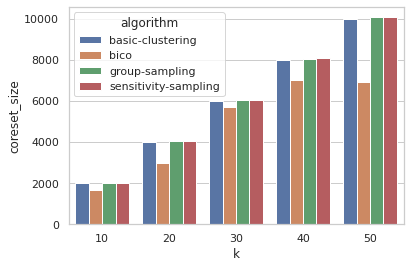

In [8]:
sns.barplot(data=df_filtered, x='k', y='coreset_size', hue='algorithm');

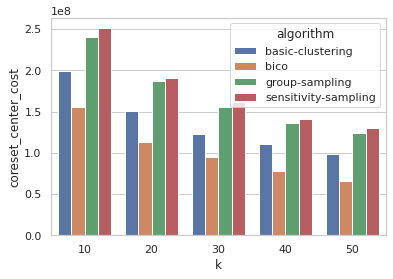

In [9]:
sns.barplot(data=df_filtered, x='k', y='coreset_center_cost', hue='algorithm');

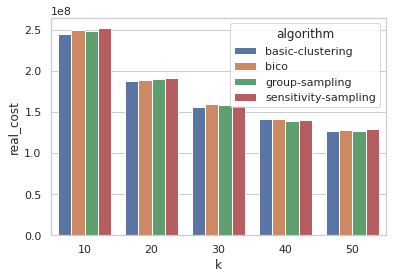

In [10]:
sns.barplot(data=df_filtered, x='k', y='real_cost', hue='algorithm');

## Costs for PCA transformed census data

In [11]:
df_filtered = df_cost_data[df_cost_data.dataset == 'censuslowd']
df_filtered

,dataset,algorithm,k,coreset_size,coreset_center_cost,real_cost,coreset_cost
20,censuslowd,basic-clustering,10,2000,2.363269e+08,2.480359e+08,2.363269e+08
21,censuslowd,basic-clustering,20,4000,1.647590e+08,1.877034e+08,1.647590e+08
22,censuslowd,basic-clustering,30,6000,1.292851e+08,1.573255e+08,1.292851e+08
23,censuslowd,basic-clustering,40,8000,1.122467e+08,1.411062e+08,1.122467e+08
24,censuslowd,basic-clustering,50,10000,1.014107e+08,1.298084e+08,1.014107e+08
25,censuslowd,bico,10,1838,2.109817e+08,2.475147e+08,2.109817e+08
26,censuslowd,bico,20,3777,1.338274e+08,1.896671e+08,1.338274e+08
27,censuslowd,bico,30,5823,9.726094e+07,1.590214e+08,9.726094e+07
28,censuslowd,bico,40,6378,7.561062e+07,1.378939e+08,7.561062e+07
29,censuslowd,bico,50,7885,6.850760e+07,1.284590e+08,6.850760e+07


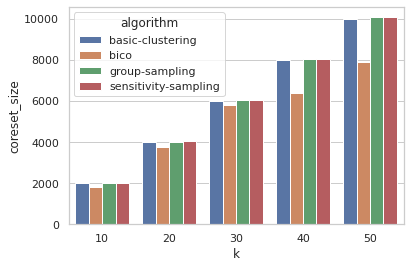

In [12]:
sns.barplot(data=df_filtered, x='k', y='coreset_size', hue='algorithm');

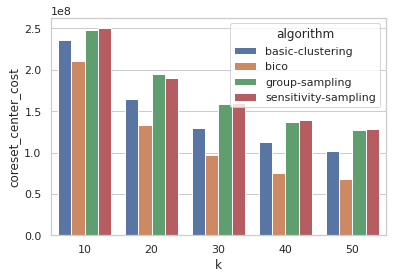

In [13]:
sns.barplot(data=df_filtered, x='k', y='coreset_center_cost', hue='algorithm');

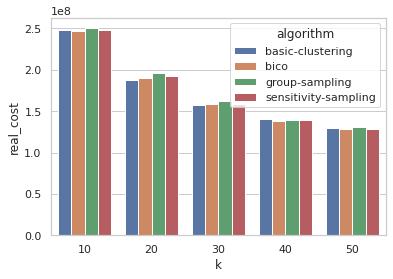

In [14]:
sns.barplot(data=df_filtered, x='k', y='real_cost', hue='algorithm');

## Costs for Covertype without PCA

In [15]:
df_filtered = df_cost_data[df_cost_data.dataset == 'covertype']
df_filtered

,dataset,algorithm,k,coreset_size,coreset_center_cost,real_cost,coreset_cost
40,covertype,basic-clustering,10,2000,3.261413e+11,3.398764e+11,3.261413e+11
41,covertype,basic-clustering,20,4000,1.960684e+11,2.044478e+11,1.960684e+11
42,covertype,basic-clustering,30,6000,1.489941e+11,1.551359e+11,1.489941e+11
43,covertype,basic-clustering,40,8000,1.238282e+11,1.287366e+11,1.238282e+11
44,covertype,basic-clustering,50,10000,1.091614e+11,1.132344e+11,1.091614e+11
45,covertype,bico,10,1795,3.092400e+11,3.404063e+11,3.092400e+11
46,covertype,bico,20,3108,1.846524e+11,2.050996e+11,1.846524e+11
47,covertype,bico,30,4766,1.416078e+11,1.561989e+11,1.416078e+11
48,covertype,bico,40,6948,1.188426e+11,1.294603e+11,1.188426e+11
49,covertype,bico,50,9579,1.058763e+11,1.137111e+11,1.058763e+11


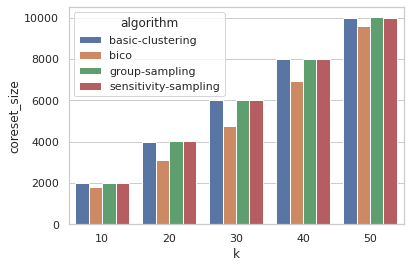

In [16]:
sns.barplot(data=df_filtered, x='k', y='coreset_size', hue='algorithm');

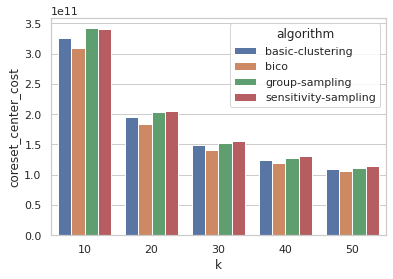

In [17]:
sns.barplot(data=df_filtered, x='k', y='coreset_center_cost', hue='algorithm');

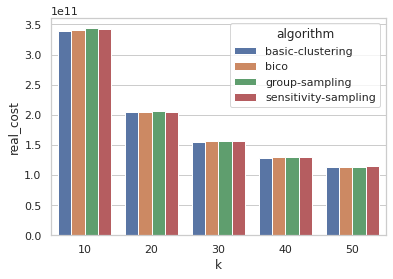

In [18]:
sns.barplot(data=df_filtered, x='k', y='real_cost', hue='algorithm');

## Costs for PCA transformed Covertype

In [19]:
df_filtered = df_cost_data[df_cost_data.dataset == 'covertypelowd']
df_filtered

,dataset,algorithm,k,coreset_size,coreset_center_cost,real_cost,coreset_cost
60,covertypelowd,basic-clustering,10,2000,3.253355e+11,3.392041e+11,3.253355e+11
61,covertypelowd,basic-clustering,20,4000,1.954251e+11,2.037897e+11,1.954251e+11
62,covertypelowd,basic-clustering,30,6000,1.484119e+11,1.545672e+11,1.484119e+11
63,covertypelowd,basic-clustering,40,8000,1.243793e+11,1.292948e+11,1.243793e+11
64,covertypelowd,basic-clustering,50,10000,1.093012e+11,1.134173e+11,1.093012e+11
65,covertypelowd,bico,10,1816,3.085893e+11,3.414390e+11,3.085893e+11
66,covertypelowd,bico,20,3133,1.831647e+11,2.035972e+11,1.831647e+11
67,covertypelowd,bico,30,4760,1.408773e+11,1.554052e+11,1.408773e+11
68,covertypelowd,bico,40,6836,1.202888e+11,1.308153e+11,1.202888e+11
69,covertypelowd,bico,50,9545,1.066385e+11,1.144296e+11,1.066385e+11


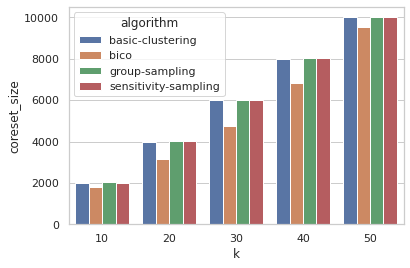

In [20]:
sns.barplot(data=df_filtered, x='k', y='coreset_size', hue='algorithm');

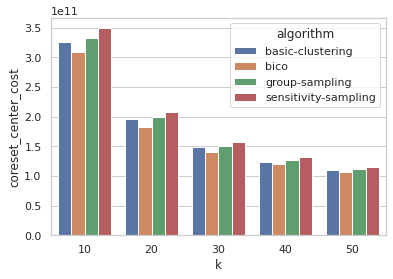

In [21]:
sns.barplot(data=df_filtered, x='k', y='coreset_center_cost', hue='algorithm');

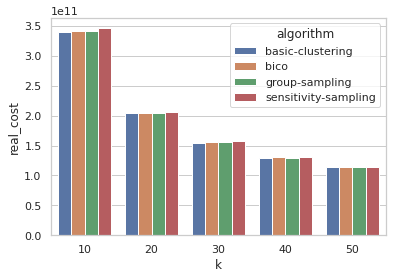

In [22]:
sns.barplot(data=df_filtered, x='k', y='real_cost', hue='algorithm');